## 1

Считываем данные

In [37]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.sandbox.stats.multicomp import multipletests

In [3]:
with open('log.txt', 'r') as f:
    lines = f.readlines()
    lines = [line.strip().split('\t') for line in lines]
    
data = pd.DataFrame()
slot = []
userId = []
ts = []
browser = []
all_cl = []
for i, line in enumerate(lines):
    if len(line) == 5:
        slot.append(line[0][5:])
        userId.append(int(line[1][7:]))
        ts.append(line[2][3:])
        browser.append(line[3][8:])
        all_cl.append(int(line[4][7:]))
    
data['slot'] = slot
data['userId'] = userId
data['ts'] = ts
data['browser'] = browser
data['all_cl'] = all_cl

In [10]:
print('Общее кол-во кликов на эксперименте = ', np.sum(data.all_cl[data.slot=='exp']))
print('Общее кол-во кликов на контроле = ', np.sum(data.all_cl[data.slot=='control']))

Общее кол-во кликов на эксперименте =  3261823
Общее кол-во кликов на контроле =  3210027


Для начала сгруппируем по user, ts и browser, чтобы не считать человека, заходившего в один и тот же день несколько раз с одного и того же браузера за разные сущности.

In [70]:
exp_groupby = pd.Series.groupby(data[data.slot=='exp'], ['userId', 'ts', 'browser']).sum()
control_groupby = pd.Series.groupby(data[data.slot=='control'], ['userId', 'ts', 'browser']).sum()

Делаем выборки при помощи бутсрепа

In [73]:
count = 5000
exp = data.all_cl[data.slot=='exp']
control = data.all_cl[data.slot=='control']
size = 300000
samples_exp = []
samples_control = []
for i in range(count):
    samples_exp.append(np.sum(np.random.choice(exp_groupby.all_cl, size)))
    samples_control.append(np.sum(np.random.choice(control_groupby.all_cl, size)))

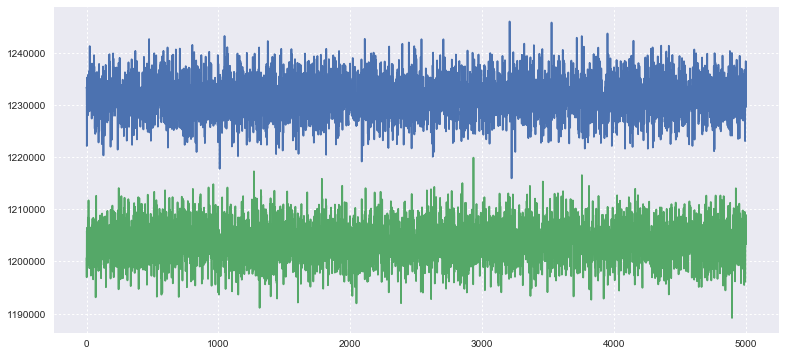

In [74]:
plt.figure(figsize=(13,6))
plt.plot(samples_exp, label='exp')
plt.plot(samples_control, label='control')
plt.grid(ls=':')
plt.legend()
plt.show()

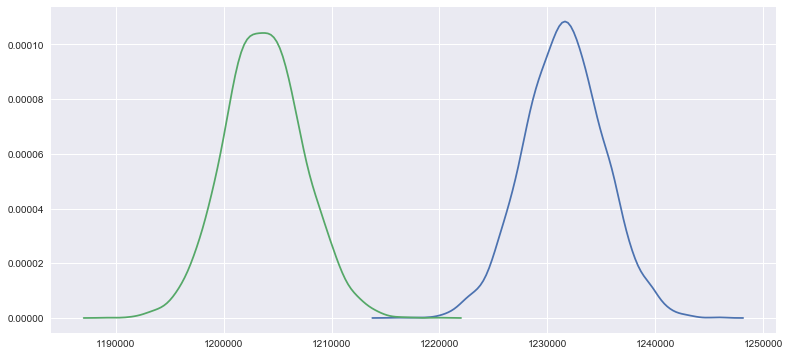

In [75]:
plt.figure(figsize=(13,6))
sns.kdeplot(np.array(samples_exp), legend=True)
sns.kdeplot(np.array(samples_control), legend=True)

Здесь уже видна разница, но мы глазам не верим, верим только критериям!

Проверим обе выборки на нормальность.

In [76]:
print(sps.shapiro(samples_exp))
print(sps.shapiro(samples_control))

(0.9997579455375671, 0.8657418489456177)
(0.9995138645172119, 0.23489226400852203)


Гипотеза о нормальности не отвергается на уровне значимости 0.05. <br>
(На самом деле приблизительная нормальность также следует из ЦПТ)

Проверим выборки на равенство дисперсий с помощью F-критерия

In [77]:
F = np.var(samples_exp) / np.var(samples_control)
p = 1 - sps.f.cdf(F, len(samples_exp), len(samples_control))
print(p)

0.259599854211535


In [78]:
# sps.bartlett(samples_exp, samples_control)

BartlettResult(statistic=0.4153996581480958, pvalue=0.5192414972770748)

Видим, что гипотеза о равенстве дисперсий не отвергается на уровне значимости 0.05

Также тут нам надо бы проверить выборки на независимость, но в случае АВТ можем этого не делать так как выборки состоят из разных пользователей и поэтому независимы. Проверим это на всякий случай : найдем пересечение 

In [230]:
print('intersection of users in exp and control : ', 
      np.intersect1d(np.unique(data.userId[data.slot=='exp']), np.unique(data.userId[data.slot=='control']), 
                     assume_unique=True))

intersection of users in exp and control :  []


Проверим гипотезу об отсутствии разницы(то есть о том, что метрики равны) при помощи t-test-а. Заметим, что мы проверили все условия для использования, осталось только понять, что элементы выборок независимы. Кажется, что это будет правдой так как в каждую бутстрепную выборку каждый элемент попадает случайно и мы имеем просто дискретное распределение. <br>
Применяем t-test

In [79]:
print(sps.ttest_rel(samples_exp, samples_control))

Ttest_relResult(statistic=372.51839312278537, pvalue=0.0)


Получили p-value

На самом деле до этого момента мы не контролировали FWER, поэтому загоним всё в множественную проверку гипотез

In [80]:
p1, p2 = sps.shapiro(samples_exp)[1], sps.shapiro(samples_control)[1]
p3, p4 = 1 - sps.f.cdf(F, len(samples_exp), len(samples_control)), sps.ttest_rel(samples_exp, samples_control)[1]
multipletests([p1, p2, p3, p4], alpha=0.05, method='holm-sidak')

(array([False, False, False,  True]),
 array([0.86574185, 0.5521137 , 0.5521137 , 0.        ]),
 0.012741455098566168,
 0.0125)

Гипотезы о нормальности выборок и равенстве дисперсий не отвергаются, в то время как гипотеза о равенстве мат. ожиданий отвергается (на уровне 0.05)

## 2


Вначале сделаем срезы по браузерам. 

Сначала проверим на нормальность каждую из полученных выборок, затем на равенство дисперсий и если все хорошо и эти гипотезы не отверглись, то применим t-test и получим результат.

Если же какая-то из первых трех гипотез отверглась, то будем пытаться применять критерий Манна-Уитни. Данный критерий требует однородности распределений, поэтому проверим однородность выборок при помощи критерия Смирнова (Колмогорова-Смирнова).

Также не забываем применять множественную проверку гипотез, так как у нас последовательность гипотез и тестов.

Так получилось, что этих двух случаев хватает и рассматривать другие методы не пришлось.

In [120]:
alpha = 0.05
count = 1000
size = 10000
    
for browser in data.browser.unique():
    new_data = data[data.browser == browser]
    exp = pd.Series.groupby(new_data[new_data.slot=='exp'], ['userId', 'ts']).sum()
    control = pd.Series.groupby(new_data[new_data.slot=='control'], ['userId', 'ts']).sum()
    
    exp_samples = []
    control_samples = []
    
    for i in range(count):
        exp_samples.append(np.sum(np.random.choice(exp.all_cl, size)))
        control_samples.append(np.sum(np.random.choice(control.all_cl, size)))
        
    p_shapiro_exp = sps.shapiro(exp_samples)[1]
    p_shapiro_control = sps.shapiro(control_samples)[1]

    F = np.var(exp_samples) / np.var(control_samples)
    p_ftest = 1 - sps.f.cdf(F, len(exp_samples), len(control_samples))
    
    p_ks = sps.ks_2samp(exp_samples -np.mean(exp_samples), control_samples - np.mean(control_samples))[1]
    
    #after multipletests all p-values can only be greater
    if p_shapiro_exp >= alpha and p_shapiro_control >= alpha and p_ftest > alpha:
        p_ttest = sps.ttest_rel(exp_samples, control_samples)[1]
        multiple = multipletests([p_shapiro_exp, p_shapiro_control, p_ftest, p_ttest], alpha=alpha, method='holm-sidak')
        
        print(browser)
        if multiple[0][-1]:
            print('Using t-test the hypotesis is rejected, p-value={}'.format(multiple[1][-1]))
        else:
            print("Using t-test the hypotesis isn't rejected, p-value={}".format(multiple[1][-1]))
    elif p_ks > alpha:
        p_mannwhitney = sps.mannwhitneyu(exp_samples, control_samples, alternative='two-sided')[1]
        multiple = multipletests([p_ks, p_mannwhitney], alpha=alpha, method='holm-sidak')
        print(browser)
        if multiple[0][-1]:
            print('Using Mann-Whitney-U test the hypotesis is rejected, p-value={}'.format(multiple[1][-1]))

        else:
            print("Using Mann-Whitney-U test the hypotesis isn't rejected, p-value={}".format(multiple[1][-1]))
    else:
        
        print(browser, p_shapiro_exp, p_shapiro_control, p_ftest, p_ks)
        print('Bad news :(')

    print()

Browser #2
Using Mann-Whitney-U test the hypotesis isn't rejected, p-value=0.17188537078314114

Browser #4
Using t-test the hypotesis is rejected, p-value=0.009889565534419109

Browser #14
Using Mann-Whitney-U test the hypotesis is rejected, p-value=0.0

Browser #17
Using Mann-Whitney-U test the hypotesis isn't rejected, p-value=0.6405981589446399

Browser #20
Using t-test the hypotesis is rejected, p-value=0.0

Browser #22
Using t-test the hypotesis is rejected, p-value=0.0



Получили, что гипотеза об одинаковости средних не отвергается для второго браузера и для 17-ого. Для остальных браузеров же найдена статистически значимая разница.

Сделаем абсолютно то же самое для срезов по датам.

In [126]:
count = 3000
size = 50000
    
for ts in data.ts.unique():
    new_data = data[data.ts == ts]
    exp = pd.Series.groupby(new_data[new_data.slot=='exp'], ['userId', 'browser']).sum()
    control = pd.Series.groupby(new_data[new_data.slot=='control'], ['userId', 'browser']).sum()
    
    exp_samples = []
    control_samples = []
    
    for i in range(count):
        exp_samples.append(np.sum(np.random.choice(exp.all_cl, size)))
        control_samples.append(np.sum(np.random.choice(control.all_cl, size)))
        
    p_shapiro_exp = sps.shapiro(exp_samples)[1]
    p_shapiro_control = sps.shapiro(control_samples)[1]

    F = np.var(exp_samples) / np.var(control_samples)
    p_ftest = 1 - sps.f.cdf(F, len(exp_samples), len(control_samples))
    
    p_ks = sps.ks_2samp(exp_samples -np.mean(exp_samples), control_samples - np.mean(control_samples))[1]
    

    if p_shapiro_exp >= alpha and p_shapiro_control >= alpha and p_ftest > alpha:
        p_ttest = sps.ttest_rel(exp_samples, control_samples)[1]
        multiple = multipletests([p_shapiro_exp, p_shapiro_control, p_ftest, p_ttest], alpha=alpha, method='holm-sidak')
        
        print(ts)
        if multiple[0][-1]:
            print('Using t-test the hypotesis is rejected, p-value={}'.format(multiple[1][-1]))
        else:
            print("Using t-test the hypotesis isn't rejected, p-value={}".format(multiple[1][-1]))
    elif p_ks > alpha:
        p_mannwhitney = sps.mannwhitneyu(exp_samples, control_samples, alternative='two-sided')[1]
        multiple = multipletests([p_ks, p_mannwhitney], alpha=alpha, method='holm-sidak')
        print(ts)
        if multiple[0][-1]:
            print('Using Mann-Whitney-U test the hypotesis is rejected, p-value={}'.format(multiple[1][-1]))

        else:
            print("Using Mann-Whitney-U test the hypotesis isn't rejected, p-value={}".format(multiple[1][-1]))
    else:
        
        print(ts, p_shapiro_exp, p_shapiro_control, p_ftest, p_ks)
        print('Bad news :(')

    print()

2016-03-03
Using t-test the hypotesis is rejected, p-value=0.0

2016-02-26
Using t-test the hypotesis is rejected, p-value=0.0

2016-03-01
Using t-test the hypotesis is rejected, p-value=0.0

2016-02-29
Using t-test the hypotesis is rejected, p-value=0.0

2016-02-28
Using Mann-Whitney-U test the hypotesis is rejected, p-value=0.0

2016-02-27
Using t-test the hypotesis is rejected, p-value=0.0

2016-03-02
Using t-test the hypotesis is rejected, p-value=0.0



Получили маленькие p-value и для каждого дня гипотеза об отсутствии эффекта (равенстве мат. ожиданий) отвергается, то есть для каждого дня отдельно была найдена статистически значимая разница.

Посмотрим сколько всего разных юзеров у нас есть.

In [130]:
print('Count of unique users : ', len(data.userId.unique()))

Count of unique users :  565842


Слишком много, поэтому нет особого смысла делать срезы по юзерам. 

В итоге получили, что для браузера 2 и 17 не наблюдается статистически значимая разница в контроле и эксперименте, для остальных же браузеров статистически значимая разница есть. <br>
Также для каждой даты получили, что разница в контроле и эксперименте значима.

## 3

Сначала посмотрим на boxplot, чтобы понять в какую сторону произошло изменение.


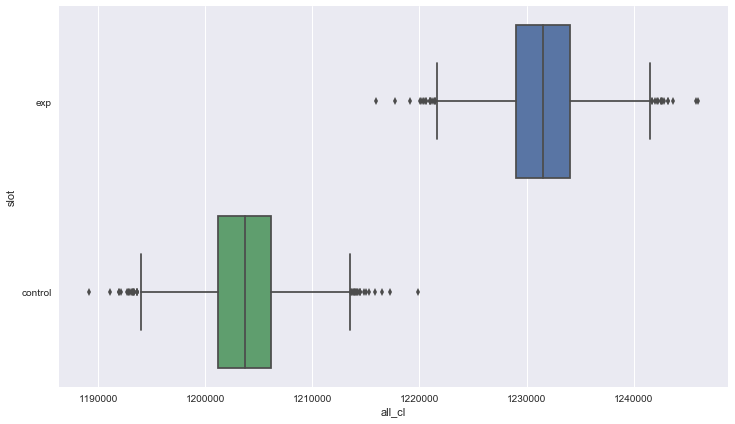

In [157]:
plt.figure(figsize=(12,7))
new_data = pd.DataFrame()
new_data['all_cl'] = np.hstack((samples_exp, samples_control))
new_data['slot'] = ['exp'] * 5000 + ['control'] * 5000
ax = sns.boxplot(x='all_cl', y='slot', data=new_data)

Видим, что общее кол-во кликов на эксперименте увеличилось. (Также здесь видно, что доверительные итервалы даже не пересекаются, что еще раз говорит о статистической значимости изменения)

    Подумаем по каким причинам это могло произойти:

   1) Выдача стала лучше (улучшилось ранжирование или что-то еще) и теперь пользователю стало интересно посещать большее число страниц в выдаче. В этом случае кажется логичным, что, кол-во запросов на пользователя должно уменьшиться или остаться тем же.
    
   2) Выдача, наоборот, стала хуже и теперь пользователю нужно смотреть большее число страниц для удовлетворения. Здесь кажется логичным предположить, что кол-во запросов на пользователя увеличится, так как теперь пользователь будет часто неудовлетворяться и пытаться переформулировать запрос.
    
    

Хотим проверить, что кол-во запросов на пользователя в эксперименте меньше, чем на контроле. Для этого будем рассматривать среднее кол-во запросов на юзера. Опять же ставим гипотезу о равенстве мат. ожиданий и пытаемся применить t-test.

In [174]:
exp_queries = pd.Series.groupby(data[data.slot=='exp'][['userId', 'all_cl']], ['userId']).count()
control_queries = pd.Series.groupby(data[data.slot=='control'][['userId', 'all_cl']], ['userId']).count()

In [199]:
count = 5000
size = 100000

samples_exp_query = []
samples_control_query = []

for i in range(count):
    samples_exp_query.append(np.mean(np.random.choice(exp_queries.all_cl, size)))
    samples_control_query.append(np.mean(np.random.choice(control_queries.all_cl, size)))

Нарисуем график полученных выборок для среднего числа запросов на юзера и boxplot

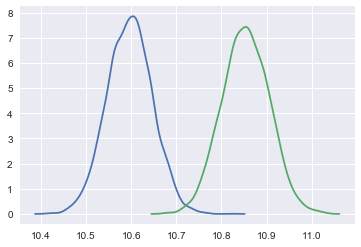

In [220]:
ax1 = sns.kdeplot(np.array(samples_exp_query), legend=True)
ax2 = sns.kdeplot(np.array(samples_control_query), legend=True)

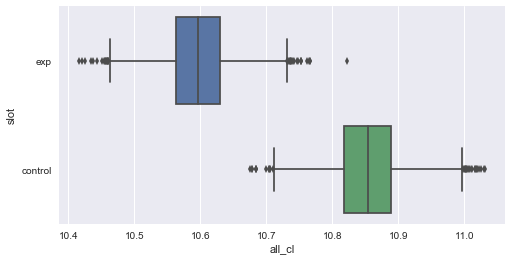

In [222]:
plt.figure(figsize=(8,4))
new_data = pd.DataFrame()
new_data['all_cl'] = np.hstack((samples_exp_query, samples_control_query))
new_data['slot'] = ['exp'] * 5000 + ['control'] * 5000
ax = sns.boxplot(x='all_cl', y='slot', data=new_data)

Здесь уже видна разница

Теперь делаем то же самое, что и в пункте 1.

Проверяем на нормальность. Получаем, что гипотеза не отвергается для обеих выборок.

In [201]:
print(sps.shapiro(samples_exp_query))
print(sps.shapiro(samples_control_query))

(0.9996852278709412, 0.661839485168457)
(0.9996646046638489, 0.5990502238273621)


Проверяем выборки на равенство дисперсий. Получаем большой p-value, гипотеза не отвергается.

In [202]:
F = np.var(samples_exp_query) / np.var(samples_control_query)
p = 1 - sps.f.cdf(F, len(samples_exp_query), len(samples_control_query))
print(p)

0.9993751641935409


Применяем t-test и получаем, что гипотеза о равенстве мат. ожиданий отвергается, то есть есть статистически значимая разница.

In [204]:
sps.ttest_rel(samples_exp_query, samples_control_query)

Ttest_relResult(statistic=-251.30726251956054, pvalue=0.0)

В итоге здесь получили, что среднее кол-во запросов на юзера в эксперименте значимо меньше, чем среднее кол-возапросов на пользователя на контроле. 
Поэтому кажется, что мы имеем дело с первым случаем и все отлично : мы улучшили выдачу.

Сделаем то же самое, что и раньше для среза по браузерам, только на этот раз гипотеза о равенстве мат. ожиданий для выборок среднего кол-ва запросов по юзеру в контроле и эксперименте.

In [237]:
alpha = 0.05
count = 1000
size = 10000
    
for browser in data.browser.unique():
    new_data = data[data.browser == browser]
    exp = pd.Series.groupby(new_data[new_data.slot=='exp'][['userId', 'all_cl']], ['userId']).count()
    control = pd.Series.groupby(new_data[new_data.slot=='control'][['userId', 'all_cl']], ['userId']).count()
    
    exp_samples = []
    control_samples = []
    
    for i in range(count):
        exp_samples.append(np.mean(np.random.choice(exp.all_cl, size)))
        control_samples.append(np.mean(np.random.choice(control.all_cl, size)))
        
    p_shapiro_exp = sps.shapiro(exp_samples)[1]
    p_shapiro_control = sps.shapiro(control_samples)[1]

    F = np.var(exp_samples) / np.var(control_samples)
    p_ftest = 1 - sps.f.cdf(F, len(exp_samples), len(control_samples))
    
    p_ks = sps.ks_2samp(exp_samples -np.mean(exp_samples), control_samples - np.mean(control_samples))[1]
    
    if p_shapiro_exp >= alpha and p_shapiro_control >= alpha and p_ftest > alpha:
        p_ttest = sps.ttest_rel(exp_samples, control_samples)[1]
        multiple = multipletests([p_shapiro_exp, p_shapiro_control, p_ftest, p_ttest], alpha=alpha, method='holm-sidak')
        
        print(browser)
        if multiple[0][-1]:
            print('Using t-test the hypotesis is rejected, p-value={}'.format(multiple[1][-1]))
        else:
            print("Using t-test the hypotesis isn't rejected, p-value={}".format(multiple[1][-1]))
    elif p_ks > alpha:
        p_mannwhitney = sps.mannwhitneyu(exp_samples, control_samples, alternative='two-sided')[1]
        multiple = multipletests([p_ks, p_mannwhitney], alpha=alpha, method='holm-sidak')
        print(browser)
        if multiple[0][-1]:
            print('Using Mann-Whitney-U test the hypotesis is rejected, p-value={}'.format(multiple[1][-1]))

        else:
            print("Using Mann-Whitney-U test the hypotesis isn't rejected, p-value={}".format(multiple[1][-1]))
    else:
        
        print(browser, p_shapiro_exp, p_shapiro_control, p_ftest, p_ks)
        print('Bad news :(')

    print()

Browser #2
Using t-test the hypotesis is rejected, p-value=0.0

Browser #4
Using Mann-Whitney-U test the hypotesis is rejected, p-value=0.0

Browser #14
Using t-test the hypotesis is rejected, p-value=0.0

Browser #17
Using t-test the hypotesis is rejected, p-value=0.0

Browser #20
Using t-test the hypotesis is rejected, p-value=0.0

Browser #22
Using t-test the hypotesis is rejected, p-value=0.0



Для всех браузеров гипотезы отвергаются, поэтому для каждого браузера есть статистически значимое изменение в среднем кол-ве запросов на пользователя.